# Solución de sistemas lineales

$ \newcommand{\mymatrix}[2]{\left[ \begin{array}{#1} #2\end{array} \right]} $

A través de un problema de ajuste de datos compareremos la eficiencia de la factorización LU (método general) y la factorización de Cholesky (método especializado) para resolver un sistema de ecuaciones lineales.

## ¿Podemos modelar el clima?

Tenemos datos de la temperatura promedio de una ciudad a lo largo de un año y queremos crear un modelo matemático que describa esa tendencia. Esto nos podría ayudar a predecir temperaturas futuras... o no. Veremos.

La temperatura real sigue una tendencia sinusoidal, para que vean que no les estoy mintiendo, aquí se grafica la temperatura mínima, máxima y media de Acapulco en el año 2014, obtenida de la página oficial de la Conagua:

https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica

https://smn.conagua.gob.mx/tools/RESOURCES/Normales_Climatologicas/Diarios/gro/dia12142.txt

La temperatura anual de las ciudades sigue una tendencia sinusoidal

$$ T(d) = \mu + A \sin [\frac{2 \pi}{365} (d - \phi)] $$

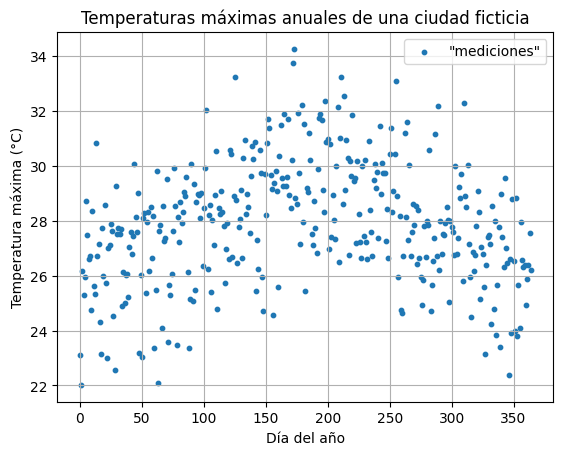

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

# vamos a generar datos sintéticos, imaginamos que tenemos 365 días
dias = np.arange(0, 365)
# la temperatura real sigue una tendencia sinusoidal
tmax_ideal = 28 + 1.5*np.sin(2*np.pi*(dias - 100)/365)
# ...pero nuestras mediciones siempre tienen algo de ruido
ruido = 2 * np.random.randn(365)
tmax = tmax_ideal + ruido

plt.scatter(dias, tmax, label='"mediciones"', s=10)
plt.xlabel('Día del año')
plt.ylabel('Temperatura máxima (°C)')
plt.title('Temperaturas máximas anuales de una ciudad ficticia')
plt.legend()
plt.grid(True)
plt.show()

Nuestro objetivo es encontrar la curva que mejor se ajuste a estos puntos. Vamos a intentar con un polinomio de grado 4

$$ p(x) = c_4 x^4 + c_3 x^3 + c_2 x^2 + c_1 x + c_0 $$

que se define por sus coeficientes $c_i$, y encontrar los mejores coeficientes nos ayuda a encontrar la mejor curva.


Para ello, utilizamos la matriz $X$ de Vandermonde, de dimensión ($m \times n$), donde cada fila es una progresión geométrica. Para un conjunto de puntos [$x_0,x_1,...,x_m$], la matriz de Vandermonde asociada a un polinomio de grado $n$ se ve así

$$ X = \mymatrix{r}{ 1 & x_1 & x_1^2 & ... & x_1^{n-1} \\ 1 & x_2 & x_2^2 & ... & x_2^{n-1} \\ ... \\ 1 & x_m & x_m^2 & ... & x_m^{n-1} } $$

y nos escupe el sistema de ecuaciones lineales $X \vec{c} = \vec{y}$, donde:

* $\vec{c}$ es el vector de coeficientes que buscamos.
* $\vec{y}$ es el vector ($m \times 1$) con nuestras medidas (`tmax`en nuestro caso).

Pero tenemos un problema... ¿cuál es?

El sistema que en realidad queremos resolver es $A \vec{c}=\vec{b}$. Hacemos la relación entre ambos usando las *Ecuaciones normales*:

$$ A = X^T X $$

$$ \vec{b} = X^T \vec{y} $$

In [23]:
# no tenemos que construir la matriz de Vandermonde a mano. NumPy lo hace por nosotros.
grado = 4
X = np.vander(dias, grado+1, increasing=True)
print("Dimensiones de la matriz de Vandermonde:", X.shape)

# sistema de ecuaciones A c = b
A = X.T @ X
b = X.T @ tmax

print("Dimensiones de la matriz A del sistema:", A.shape)
print("Dimensiones del vector b del sistema:", b.shape)
#print(A)

Dimensiones de la matriz de Vandermonde: (365, 5)
Dimensiones de la matriz A del sistema: (5, 5)
Dimensiones del vector b del sistema: (5,)


### Factorización LU

Este método funciona para cualquier matriz cuadrada invertible.

In [24]:
# es invertible porque su determinante no es cero
np.linalg.det(A)

np.float64(-7.177959494485362e+58)

In [25]:
# primero factorizamos A, este paso es costoso.
from scipy.linalg import lu, solve_triangular

P, L, U = lu(A)

# sustitución hacia adelante y hacia atrás
# Resolver Ly = Pb
y = solve_triangular(L, P @ b, lower=True)
# Resolver Uc = y
coeffs_lu = solve_triangular(U, y, lower=False)

print("Coeficientes del polinomio encontrados con LU:")
print(coeffs_lu)

Coeficientes del polinomio encontrados con LU:
[ 2.51641276e+01  4.25712373e-02 -1.13766899e-04  1.49464722e-10
  9.63272572e-13]


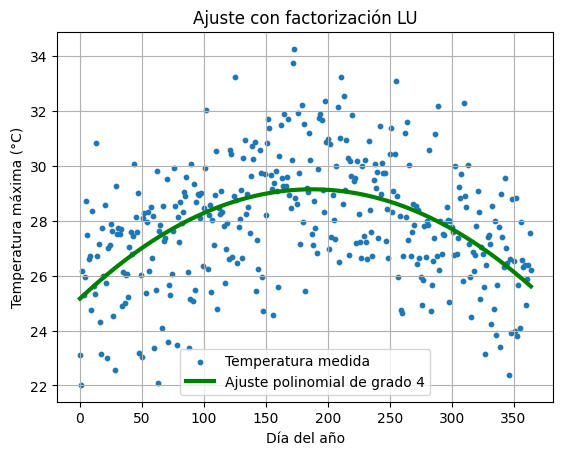

In [26]:
# creamos la función del polinomio a partir de los coeficientes
fitpol = np.poly1d(np.flip(coeffs_lu)) # np.poly1d espera coefs de mayor a menor grado
temp_LU = fitpol(dias)

plt.scatter(dias, tmax, s=10, label='Temperatura medida')
plt.plot(dias, temp_LU, color='green', linewidth=3, label=f'Ajuste polinomial de grado {grado}')
plt.xlabel('Día del año')
plt.ylabel('Temperatura máxima (°C)')
plt.title('Ajuste con factorización LU')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# aquí checo que A es simétrica para introducir la factorización de Cholesky
print(np.allclose(A, A.T))

True


### Factorización de Cholesky

Cuando una matriz es simétrica y definida positiva (SPD), podemos usar un algoritmo mucho más eficiente y estable.

In [8]:
# la descomposición de Cholesky es A = L * L^T
from scipy.linalg import cholesky

try:
    L = cholesky(A)
    # Resolver Ly = b
    y = solve_triangular(L, b, lower=True)
    # Resolver L^T c = y
    coeffs_chol = solve_triangular(L.T, y, lower=False)
    
    print("Coeficientes encontrados con Cholesky:")
    print(coeffs_chol)
    print("La factorización de Cholesky tuvo éxito (inesperado :o).")
except np.linalg.LinAlgError as e:
    print(f"La factorización de Cholesky falló: {e}")

print()
print(f"eigenvalores de A: {np.linalg.eigvals(A)}")
print(f"Número de condición: {np.linalg.cond(A):.2e}")

La factorización de Cholesky falló: 5-th leading minor of the array is not positive definite

eigenvalores de A: [ 2.94351267e+18 -1.37911941e+18  4.01641021e+14  1.34751734e+02
  1.06759865e+06]
Número de condición: 7.14e+16


El número de condición es muuuuuy grande. Esto significa que la matriz es numéricamente singular y perderíamos toda la precisión. Cholesky falla porque los errores de punto flotante hacen que la matriz ya no parezca definida positiva para la computadora.

<small> Lo que hace que el número de condición sea así de grande viene de que las columnas de la matriz de Vandermonde (la base polinomial) no sean del todo independientes para ciertos valores de $x$ y sus valores estén muy cercanos entre sí, y entonces ocurre una cancelación catrastófica en cadena.

No todos los problemas matemáticamente correctos tienen formulaciones computacionalmente estables. :(

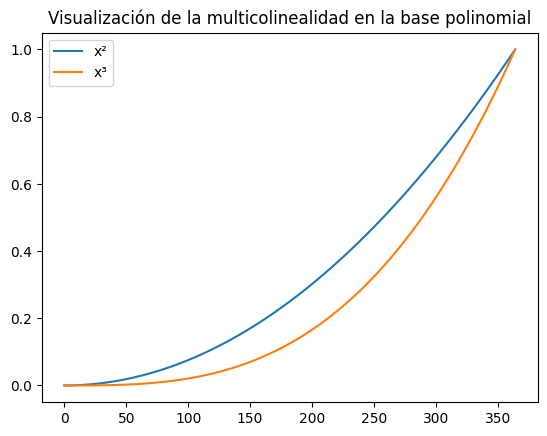

In [9]:
#plt.plot(dias, X[:, 1], label='x')
plt.plot(dias, X[:, 2]/np.max(X[:,2]), label='x²')
plt.plot(dias, X[:, 3]/np.max(X[:,3]), label='x³')
plt.title('Visualización de la multicolinealidad en la base polinomial')
plt.legend()
plt.show()

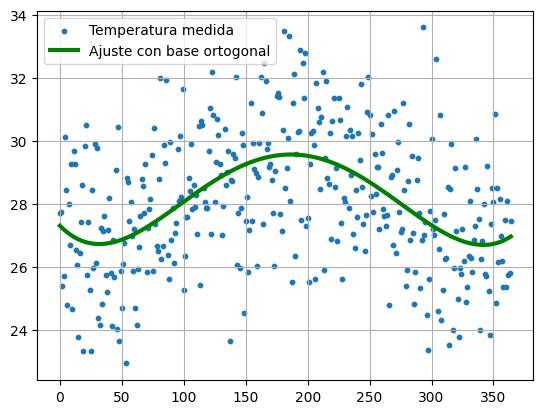

In [10]:
pol = np.polynomial.Polynomial.fit(dias, tmax, deg=grado)
# este método es numéricamente estable y nos da los coeficientes directamente
tmax_estable = pol(dias)

plt.scatter(dias, tmax, s=10, label='Temperatura medida')
plt.plot(dias, tmax_estable, color='green', linewidth=3, label='Ajuste con base ortogonal')
plt.legend()
plt.grid(True)
plt.show()

Como la base $1, x^2, x^3, x^4$ es el problema, podemos replantear el problema cambiando de base. Los llamados **polinomios ortogonales** están diseñados para esto.

No lo haremos nosotros :)

## Equilibrio térmico en una barra

Tenemos una barra metálica de 1 metro. Mantenemos el extremo izquierdo a 100°C y el extremo derecho a 0°C y queremos saber cuál será la temperatura en cada punto de la barra una vez que el calor se estabilice.

Para resolver esto numéricamente, dividimos la barra en $n$ segmentos, y usamos que en estado estacionario la temperatura en cualquier punto es el promedio de la temperatura de sus vecinos inmediatos.

$$ T_i = \frac{T_{i-1} + T_{i+1}}{2} $$
$$ \Rightarrow 2T_i - T_{i-1} - T_{i+1} = 0 $$

Esto es un sistema de ecuaciones lineales, wuuu.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000# número de puntos interiores
T0 = 100 # temperatura en el extremo izquierdo (x=0)
Tn = 0 # temperatura en el extremo derecho (x=1)

# la matriz A representa la relación '2T_i - T_{i-1} - T_{i+1}'
A = np.zeros((n, n))
for i in range(n):
    A[i, i] = 2 # término 2*T_i
    if i > 0:
        A[i, i-1] = -1 # término -T_{i-1}
    if i < n-1:
        A[i, i+1] = -1 # término -T_{i+1}

# el vector b viene de las condiciones de frontera (los extremos)
b = np.zeros(n)
b[0] = T0 # el primer punto T_1 está junto a T0
b[-1] = Tn # el último punto T_n está junto a T_{n+1}

#print(A)
#print(b)

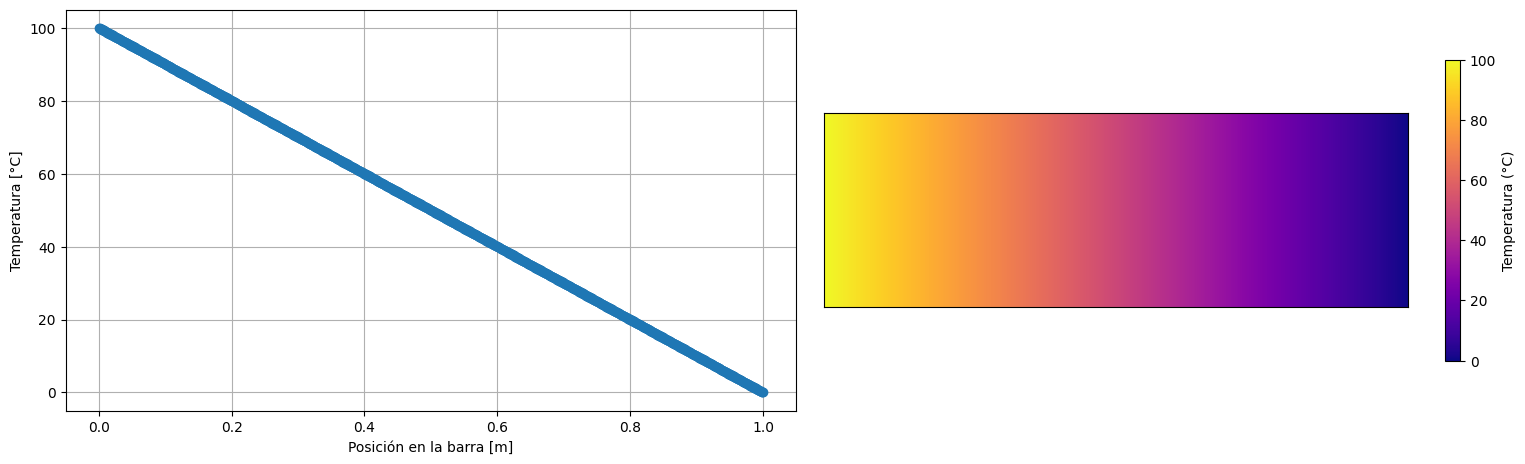

In [12]:
from scipy.linalg import lu, cholesky, solve_triangular

# Factorización LU
P, L, U = lu(A)
y = solve_triangular(L, P @ b, lower=True)
lu = solve_triangular(U, y, lower=False)

# Añadimos los extremos para el graficar
barra = np.linspace(0, 1, n + 2)
temp = np.concatenate(([T0], lu, [Tn]))

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(barra, temp, marker='o')
axs[0].set_xlabel('Posición en la barra [m]')
axs[0].set_ylabel('Temperatura [°C]')
axs[0].grid(True)

altura = int(n/3) # hacemos la barra rectangular
heatmap = np.broadcast_to(temp, (altura, n + 2))
im = axs[1].imshow(heatmap, cmap='plasma')
axs[1].set_xticks([])
axs[1].set_yticks([])
fig.colorbar(im, ax=axs[1], label='Temperatura (°C)', shrink=0.75)
plt.tight_layout(pad=2.0)
plt.show()

In [13]:
# A es simétrica :)
np.allclose(A, A.T)

True

In [14]:
# y también definida positiva :)
evals = np.linalg.eigvals(A)
np.all(evals > 0)

np.True_

In [15]:
L = np.linalg.cholesky(A)
y = solve_triangular(L, b, lower=True)
chol = solve_triangular(L.T, y, lower=False)
# veamos que resolver con LU y con Choleky nos da el mismo resultado
np.allclose(lu, chol)

True

In [16]:
import timeit

n = 500
A = np.diag(np.full(n, 2.0)) - np.diag(np.ones(n-1), k=1) - np.diag(np.ones(n-1), k=-1)

# Tiempo para LU
stmt_lu = "lu(A)"
setup_lu = "from scipy.linalg import lu; from __main__ import A"
tiempo_lu = timeit.timeit(stmt=stmt_lu, setup=setup_lu, number=100)
print(f"LU (100 ejecuciones): {tiempo_lu:.6f} segundos")

# Tiempo para Cholesky
stmt_chol = "np.linalg.cholesky(A)"
setup_chol = "import numpy as np; from __main__ import A"
tiempo_chol = timeit.timeit(stmt=stmt_chol, setup=setup_chol, number=100)
print(f"Cholesky (100 ejecuciones): {tiempo_chol:.6f} segundos")

speedup = tiempo_lu / tiempo_chol
print(f"Cholesky es ~{speedup:.2f} veces más rápido.")

LU (100 ejecuciones): 0.639545 segundos
Cholesky (100 ejecuciones): 0.351626 segundos
Cholesky es ~1.82 veces más rápido.


## Regularización de un grid

Tenemos una cuadrícula de puntos, pero los puntos interiores se han desordenado por alguna razón (?. Queremos 'suavizar' la malla, moviendo cada punto interior a una posición más ordenada y manteniendo los bordes fijos.

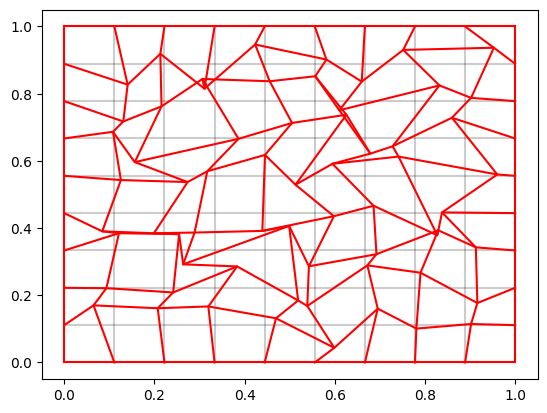

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scipy.linalg import lu, cholesky, solve_triangular

# comenzamos con una cuadrícula de 10x10
N = 10 
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
X0, Y0 = np.meshgrid(x, y)

# dañamos los puntos interiores añadiendo ruido aleatorio
ruido = 0.15
ruido_x = (np.random.rand(N - 2, N - 2) - 0.5) * ruido
ruido_y = (np.random.rand(N - 2, N - 2) - 0.5) * ruido

X = X0.copy()
Y = Y0.copy()
X[1:-1, 1:-1] += ruido_x
Y[1:-1, 1:-1] += ruido_y

plt.plot(X0, Y0, 'k-', alpha=0.2) # Malla original
plt.plot(X0.T, Y0.T, 'k-', alpha=0.2)
plt.plot(X, Y, 'r-') # Malla ruidosa
plt.plot(X.T, Y.T, 'r-')
plt.show()

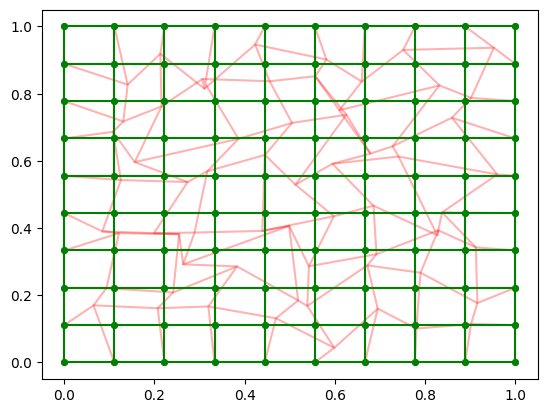

In [18]:
def suavizar(N, X, Y):
    """Construye la matriz A y los vectores b para el problema de suavizado."""
    n = (N - 2) * (N - 2) # número de incognitas
    A = np.zeros((n, n))
    bx = np.zeros(n)
    by = np.zeros(n)
    
    k = 0
    for i in range(1, N - 1): # recorremos solo los puntos interiores
        for j in range(1, N - 1):
            A[k, k] = 4
            # Vecinos
            if i > 1: A[k, k - (N - 2)] = -1
            else: # borde superior
                bx[k] += X[0, j]
                by[k] += Y[0, j]
            
            if i < N - 2: A[k, k + (N - 2)] = -1
            else: # borde inferior
                bx[k] += X[N-1, j]
                by[k] += Y[N-1, j]

            if j > 1: A[k, k - 1] = -1
            else: # borde izquierdo
                bx[k] += X[i, 0]
                by[k] += Y[i, 0]
            
            if j < N - 2: A[k, k + 1] = -1
            else: # borde derecho
                bx[k] += X[i, N-1]
                by[k] += Y[i, N-1]
            
            k += 1
    return A, bx, by

# construimos y resolvemos el sistema
A, bx, by = suavizar(N, X, Y)

# resolver para X con LU
P, L, U = lu(A)
x = solve_triangular(L, P @ bx, lower=True)
sol_x = solve_triangular(U, x, lower=False)

# resolver para Y con LU
y = solve_triangular(L, P @ by, lower=True)
sol_y = solve_triangular(U, y, lower=False)

# armamos la malla suavizada
X_suave = X0.copy()
Y_suave = Y.copy()
X_suave[1:-1, 1:-1] = sol_x.reshape((N - 2, N - 2))
Y_suave[1:-1, 1:-1] = sol_y.reshape((N - 2, N - 2))

plt.plot(X, Y, 'r-', alpha=0.3)
plt.plot(X.T, Y.T, 'r-', alpha=0.3)
plt.plot(X_suave, Y_suave, 'g-o', markersize=4)
plt.plot(X_suave.T, Y_suave.T, 'g-o', markersize=4)
plt.show()

In [19]:
# una malla de 50x50 genera una matriz de 2304x2304
N = 50
A, _, _ = suavizar(N, np.zeros((N, N)), np.zeros((N, N)))

# método LU
lu_func = lambda: lu(A)
tiempo_lu = timeit.timeit(lu_func, number=5)
print(f"LU (5 ejecuciones): {tiempo_lu:.4f} segundos")

# Cholesky
chol_func = lambda: cholesky(A)
tiempo_chol = timeit.timeit(chol_func, number=5)
print(f"Cholesky (5 ejecuciones): {tiempo_chol:.4f} segundos")

speedup = tiempo_lu / tiempo_chol
print(f"Cholesky es ~{speedup:.2f} veces más rápido.")

LU (5 ejecuciones): 0.9869 segundos
Cholesky (5 ejecuciones): 0.4769 segundos
Cholesky es ~2.07 veces más rápido.
